<a href="https://colab.research.google.com/github/robimalco/colab/blob/main/Home_Credit_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADD KEYS

In [ ]:
!rm -rf *

import os
os.environ['KAGGLE_USERNAME'] = "robimalco" # username from the json file
os.environ['KAGGLE_KEY'] = "0f4600b98146814d7a153f58c4cf4389" # key from the json file
!pip install -q kaggle
!kaggle competitions download -c home-credit-default-risk

# START SETUP

In [ ]:
!unzip application_test.csv.zip
!unzip application_train.csv.zip
# !unzip POS_CASH_balance.csv.zip
# !unzip bureau.csv.zip
# !unzip bureau_balance.csv.zip
# !unzip credit_card_balance.csv.zip
# !unzip installments_payments.csv.zip
# !unzip previous_application.csv.zip

In [4]:
!pip install torch==1.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

import datetime

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import random
import string
letters = string.ascii_lowercase

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('mode.chained_assignment', None)

In [ ]:
!pip install --upgrade gspread
from google.colab import auth, drive
import gspread
from oauth2client.client import GoogleCredentials
drive.mount('/drive')
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1M-CqsTbBu7ScY4mZBcpI8kPbI7F-BE8aPTC4UknumYk/edit#gid=0')
sheet = wb.worksheet('Data')
def get_next_row(worksheet):
    str_list = list(filter(None, worksheet.col_values(1)))
    return str(len(str_list)+1)

# SET HYPERPARAMETERS

In [68]:
hp_test_size = 0.2
hp_emb_drop = 0.04
hp_layers = [800, 300]
hp_ps = [0.001,0.01]
hp_lr= 0.001
hp_epochs = 4

# Files

*   application_{train|test}.csv --> main table, static data for all applications. One row represents one loan in our data sample.
*   bureau.csv -->  client's previous credits, for every loan in our sample, there are as many rows as number of credits the client had.
*   bureau_balance.csv --> monthly balances of previous credits, one row for each month.
*   POS_CASH_balance.csv --> monthly balance snapshots of previous point of sales and cash loans that the applicant had, one row for each month.
*   credit_card_balance.csv --> monthly balance snapshots of previous credit cards, one row for each month.
*   previous_application.csv --> all previous applications for Home Credit loans of clients who have loans.
*   installments_payments.csv --> repayment history for the previously disbursed credits.

# LOAD DATA

In [129]:
application_train_df = pd.read_csv('application_train.csv').sample(frac = 1)
application_test_df = pd.read_csv('application_test.csv')
# bureau_df = pd.read_csv('bureau.csv')
# bureau_balance_df = pd.read_csv('bureau_balance.csv')
# pos_cash_balance_df = pd.read_csv('POS_CASH_balance.csv')
# credit_card_balance_df = pd.read_csv('credit_card_balance.csv')
# previous_application_df = pd.read_csv('previous_application.csv')
# installments_payments_df = pd.read_csv('installments_payments.csv')

In [130]:
# application_train_df = application_train_df.head(round(application_train_df.shape[0] * 0.5))
# application_test_df = application_test_df.head(round(application_test_df.shape[0] * 0.3))

In [131]:
application_train_df['CSV_SOURCE'] = 'application_train.csv'
application_test_df['CSV_SOURCE'] = 'application_test.csv'
df = pd.concat([application_train_df, application_test_df])

# UTILITIES

In [132]:
def generate_timestamp():
  now = datetime.datetime.now()
  year = '{:02d}'.format(now.year)
  month = '{:02d}'.format(now.month)
  day = '{:02d}'.format(now.day)
  hour = '{:02d}'.format(now.hour)
  minute = '{:02d}'.format(now.minute)
  return '{}-{}-{} {}:{}'.format(year, month, day, hour, minute)

In [133]:
def order_columns_alphabetically(input_df):
  input_df_columns = list(input_df.columns)
  input_df_columns.sort()
  return input_df[input_df_columns]

In [134]:
def split_columns_by_type(input_df):
  numerical_columns = []
  categorical_columns = []
  for column in input_df.columns:
    if input_df.dtypes[column] == np.int64 or input_df.dtypes[column] == np.float64:
      numerical_columns.append(column)
    else:
      categorical_columns.append(column)
  return numerical_columns, categorical_columns

In [135]:
# threshold = 60
def convert_numerical_to_categorical(input_df):
  for column in input_df.columns:
    if column == 'TARGET':
      pass
    elif input_df.dtypes[column] == np.int64 or input_df.dtypes[column] == np.float64:
      if len(input_df[column].unique()) < 60:
        input_df[column] = input_df[column].astype('string')
  return input_df

In [136]:
def smart_overview(input_df):
  a_types = []
  a_countUnique = []
  a_missing = []
  a_missing_perc = []
  a_corrTarget = []
  a_min = []
  a_max = []
  a_mean = []
  a_median = []
  a_quantile = []
  for column in input_df.columns:
    x = input_df[column]
    x_type = input_df.dtypes[column]
    countUnique = len(x.unique())
    missing = x.isnull().sum()
    missing_perc = round((missing/input_df.shape[0]),3)*100
    if x_type == np.int64 or x_type == np.float64:
      a_corrTarget.append(round(x.corr(input_df['TARGET']), 3))
      a_min.append(x.min())
      a_max.append(x.max())
      a_mean.append(x.mean())
      a_median.append(x.median())
      a_quantile.append(x.quantile(0.5))
    else:
      a_corrTarget.append('')
      a_min.append('')
      a_max.append('')
      a_mean.append('')
      a_median.append('')
      a_quantile.append('')
    a_types.append(x_type)
    a_countUnique.append(countUnique)
    a_missing.append(missing)
    a_missing_perc.append(missing_perc)
  explore_df = pd.DataFrame({
    'Columns': input_df.columns,
    'Types': a_types,
    'Unique': a_countUnique,
    'Missing': a_missing,
    'Missing%': a_missing_perc,
    'CorrTarget': a_corrTarget,
    'Min': a_min,
    'Max': a_max,
    'Mean': a_mean,
    'Median': a_median,
    'Quantile': a_quantile
  })
  explore_df.set_index('Columns', inplace=True)
  return explore_df.transpose()

# MANAGE COLUMNS (NUMERICAL VS CATEGORICAL)

In [137]:
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: abs(round(x / 2000))).astype('string')
df['DAYS_ID_PUBLISH'] = df['DAYS_ID_PUBLISH'].apply(lambda x: abs(round(x / 2000))).astype('string')
df['DAYS_REGISTRATION'] = df['DAYS_REGISTRATION'].apply(lambda x: abs(round(x / 2000))).astype('string')

In [138]:
df = order_columns_alphabetically(df)
df = convert_numerical_to_categorical(df)
columns_type = split_columns_by_type(df)
numerical_columns = columns_type[0]
categorical_columns = columns_type[1]

In [139]:
numerical_columns = ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE']
categorical_columns = ['CODE_GENDER', 'CSV_SOURCE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION']
target_column = ['TARGET']

In [140]:
df = df[numerical_columns + categorical_columns + target_column]

In [ ]:
smart_overview(df)

# MANAGE MISSING VALUES

In [143]:
for numerical_column in numerical_columns:
  df[numerical_column].fillna(value=df[numerical_column].median(), inplace=True)

# STANDARDISE

In [144]:
min_max_scaler = preprocessing.MinMaxScaler()
df[numerical_columns] = pd.DataFrame(min_max_scaler.fit_transform(df[numerical_columns]))

# CONVERT CATEGORICAL COLUMNS INTO TYPE "CATEGORY"

In [145]:
categorical_columns.remove('CSV_SOURCE')

for column in categorical_columns:
  df[column] = LabelEncoder().fit_transform(df[column].astype(str))
  df[column] = df[column].astype('category')

# SPLIT DATA INTO TRAINING vs TRAIN

In [146]:
train_df = df[df['CSV_SOURCE'] == 'application_train.csv']
train_output_df = pd.DataFrame(train_df['TARGET'], columns=['TARGET'])

test_df = df[df['CSV_SOURCE'] == 'application_test.csv']

# REMOVE NOT USEFUL COLUMNS

In [147]:
train_df.drop(columns=['CSV_SOURCE', 'TARGET'], axis=0, inplace=True)
test_df.drop(columns=['CSV_SOURCE', 'TARGET'], axis=0, inplace=True)

# CREATE VALIDATION SET

In [148]:
x_train, x_validation, y_train, y_validation = train_test_split(train_df, train_output_df, test_size=hp_test_size, random_state=42)

# CREATE TENSORS

In [149]:
def create_tensors(input_df):
  stack = []
  for column in input_df.columns:
    if input_df.dtypes[column] == np.int64 or input_df.dtypes[column] == np.float64:
      stack.append(input_df[column].astype(np.float64))
    else:
      stack.append(input_df[column].cat.codes.values)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)

tensor_x_train_cat = create_tensors(x_train[categorical_columns]).float().to(device)
tensor_x_train_num = create_tensors(x_train[numerical_columns]).float().to(device)
tensor_y_train = torch.tensor(y_train.values).flatten().float().to(device)

tensor_x_valid_cat = create_tensors(x_validation[categorical_columns]).float().to(device)
tensor_x_valid_num = create_tensors(x_validation[numerical_columns]).float().to(device)
tensor_y_valid = torch.tensor(y_validation.values).flatten().float().to(device)

tensor_x_test_cat = create_tensors(test_df[categorical_columns]).float().to(device)
tensor_x_test_num = create_tensors(test_df[numerical_columns]).float().to(device)

# CREATE CATEGORICAL EMBEDDING SIZES

In [150]:
categorical_columns_size = [len(df[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size + 1) // 2)) for col_size in categorical_columns_size]

# CREATE PYTORCH DATA LOADER

In [151]:
train_tensor_dataset = TensorDataset(tensor_x_train_cat, tensor_x_train_num, tensor_y_train)
train_loader = DataLoader(dataset=train_tensor_dataset, batch_size=16, shuffle=True)

# DEFINE NEURAL NETWORK MODEL

![](https://yashuseth.files.wordpress.com/2018/07/model1.png)


In [152]:
class Model(nn.Module):
  def __init__(self, embedding_size, input_size, num_numerical_cols, layers, ps):
    super().__init__()

    self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
    self.emb_drop = nn.Dropout(hp_emb_drop)

    self.bn_cont = nn.BatchNorm1d(num_numerical_cols)

    layerlist = []
    for i, elem in enumerate(layers):
      layerlist.append(nn.Linear(input_size, elem))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(layers[i]))
      layerlist.append(nn.Dropout(ps[i]))
      input_size = elem
    layerlist.append(nn.Linear(layers[-1], 1))

    self.layers = nn.Sequential(*layerlist)

  def forward(self, x_c, x_n):

    embeddings = [e(x_c[:,i].long()) for i, e in enumerate(self.all_embeddings)]

    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)

    x_n = self.bn_cont(x_n)

    x = torch.cat([x, x_n], 1)
    x = self.layers(x)

    return x

# INSTANTIATE NEURAL NETWORK MODEL

In [153]:
num_numerical_cols = tensor_x_train_num.shape[1]

num_categorical_cols = sum((nf for ni, nf in categorical_embedding_sizes))
initial_input_size = num_categorical_cols + num_numerical_cols

model = Model(categorical_embedding_sizes, initial_input_size, num_numerical_cols, layers=hp_layers, ps=hp_ps)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hp_lr)
model.to(device)
tot_losses = []

# TRAIN NEURAL NETWORK MODEL

In [ ]:
start_training = generate_timestamp()

for epoch in range(hp_epochs):
  train_losses = []
  for x_cat, x_num, y in train_loader:
    y_pred = model(x_cat, x_num)
    single_loss = torch.sqrt(loss_function(y_pred.squeeze(), y))
    optimizer.zero_grad()
    single_loss.backward() 
    optimizer.step()
    train_losses.append(single_loss.item())
  epoch_loss = 1.0 * sum(train_losses) / len(train_losses)
  tot_losses.append(epoch_loss)
  print("epoch: " + str(epoch) + "\tloss: " + str(epoch_loss))
plt.plot(tot_losses)
plt.show()

end_training = generate_timestamp()

# VALIDATE NEURAL NETWORK

In [155]:
validation_tensor_dataset = TensorDataset(tensor_x_valid_cat, tensor_x_valid_num, tensor_y_valid)
validation_loader = DataLoader(dataset=validation_tensor_dataset, batch_size=16, shuffle=True)

valid_losses = []

with torch.no_grad():
  for x_cat, x_num, y in validation_loader:
    y_valid = model(x_cat, x_num)
    validation_loss = torch.sqrt(loss_function(y_valid.squeeze(), y))
    valid_losses.append(validation_loss.item())
  valid_loss = str(round(1.0 * sum(valid_losses) / len(valid_losses), 5))
  print("loss: " + valid_loss)

loss: 0.23926


# MAKE PREDICTIONS

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6783b1c4a8>]],
      dtype=object)

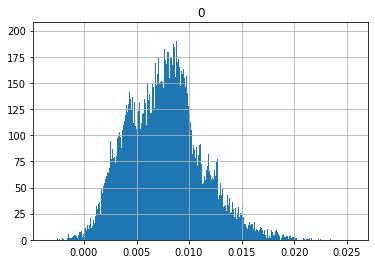

In [156]:
with torch.no_grad():
  y_test = model(tensor_x_test_cat, tensor_x_test_num)
pd.DataFrame(y_test).astype("float").hist(bins=1000)

# SAVE PREDICTIONS

In [157]:
prediction_id = ''.join(random.choice(letters) for i in range(5))
prediction_df = pd.DataFrame(y_test).astype("float")
x_scaled = min_max_scaler.fit_transform(prediction_df)
prediction_df = pd.DataFrame(x_scaled)
prediction_df = pd.concat([prediction_df, application_test_df['SK_ID_CURR']], axis=1)
prediction_df.columns = ['TEMP_TARGET', 'SK_ID_CURR']
prediction_df['TARGET'] = round(prediction_df['TEMP_TARGET'], 1)
prediction_df = prediction_df[['SK_ID_CURR', 'TARGET']]
prediction_df.to_csv('/drive/My Drive/pycharm_colab_training/kaggle/HomeCreditDefaultRisk/submissions/' + prediction_id + '.csv', index=False)
test_target_mean = str(round(prediction_df['TARGET'].mean(), 3))
test_distrbution = prediction_df.groupby(by=['TARGET'])['TARGET'].count()
print("test_target_mean:", test_target_mean)
print(test_distrbution.to_string(header=False))

test_target_mean: 0.38
0.00000       16
0.10000      808
0.20000     6772
0.30000    12488
0.40000    15915
0.50000     8191
0.60000     3379
0.70000      888
0.80000      261
0.90000       24
1.00000        2


# SAVE DATA TO SHEET



In [158]:
model_values_dict = {
  'ID': prediction_id,
  'start_training': start_training,
  'end_training': end_training,
  'perc_test_size': hp_test_size,
  'emb_drop': hp_emb_drop,
  'layers': '\n'.join([str(i) for i in hp_layers]),
  'ps': '\n'.join([str(i) for i in hp_ps]),
  'lr': hp_lr,
  'epochs': hp_epochs,
  'train_losses': '\n'.join([str(round(i, 5)) for i in tot_losses]),
  'valid_loss': valid_loss,
  'test_target_mean': test_target_mean,
  'test_distrbution': test_distrbution.to_string(header=False),
  'numerical_columns': len(numerical_columns),
  'categorical_columns': len(categorical_columns),
  'model_parameters': str(model.parameters)
}

next_row = get_next_row(sheet)
cells = sheet.range('A' + next_row + ':P' + next_row)
model_values_list = list(model_values_dict.values())
for i, cell in enumerate(cells):
  cell.value = model_values_list[i]
sheet.update_cells(cells)

{'spreadsheetId': '1M-CqsTbBu7ScY4mZBcpI8kPbI7F-BE8aPTC4UknumYk',
 'updatedCells': 16,
 'updatedColumns': 16,
 'updatedRange': 'Data!A5:P5',
 'updatedRows': 1}